In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [44]:
# Load the dataset from the CSV file
wine_data = pd.read_csv("../../data/raw/winequality-red.csv", delimiter=',')


In [45]:
print("Dataset shape:", wine_data.shape)  # (rows, columns) Checks how many samples and features exist. 
display(wine_data.head())  # First 5 rows
print(wine_data.info())  # Data types & missing values
display(wine_data.describe())  # Provides statistical measures (mean, std, min, max, etc.).

Dataset shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#  <span style="color: blue;"> Data Preprocessing <span>

## <span style="color: orange;"> Missing Values Check <span>

In [46]:
print("\nMissing values per column:")
print(wine_data.isnull().sum())


Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


Ensures there are no missing values before proceeding.

## <span style="color: orange;"> Outlier Detection & Capping <span>

### Outlier Detection (IQR Method)

* IQR (Interquartile Range) = Q3 - Q1

* Outliers are values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR.

* This method is robust to extreme values compared to Z-score.

In [ ]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

### Outlier Capping (Clipping Extreme Values)

In [ ]:
# Define outlier capping function
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower, upper)

In [ ]:
# Handle outliers FIRST (on a copy)
wine_cleaned = wine_data.copy()
for col in wine_cleaned.columns[:-1]:  # exclude 'quality'
    cap_outliers_iqr(wine_cleaned, col)


## Boxplots After Outlier Capping

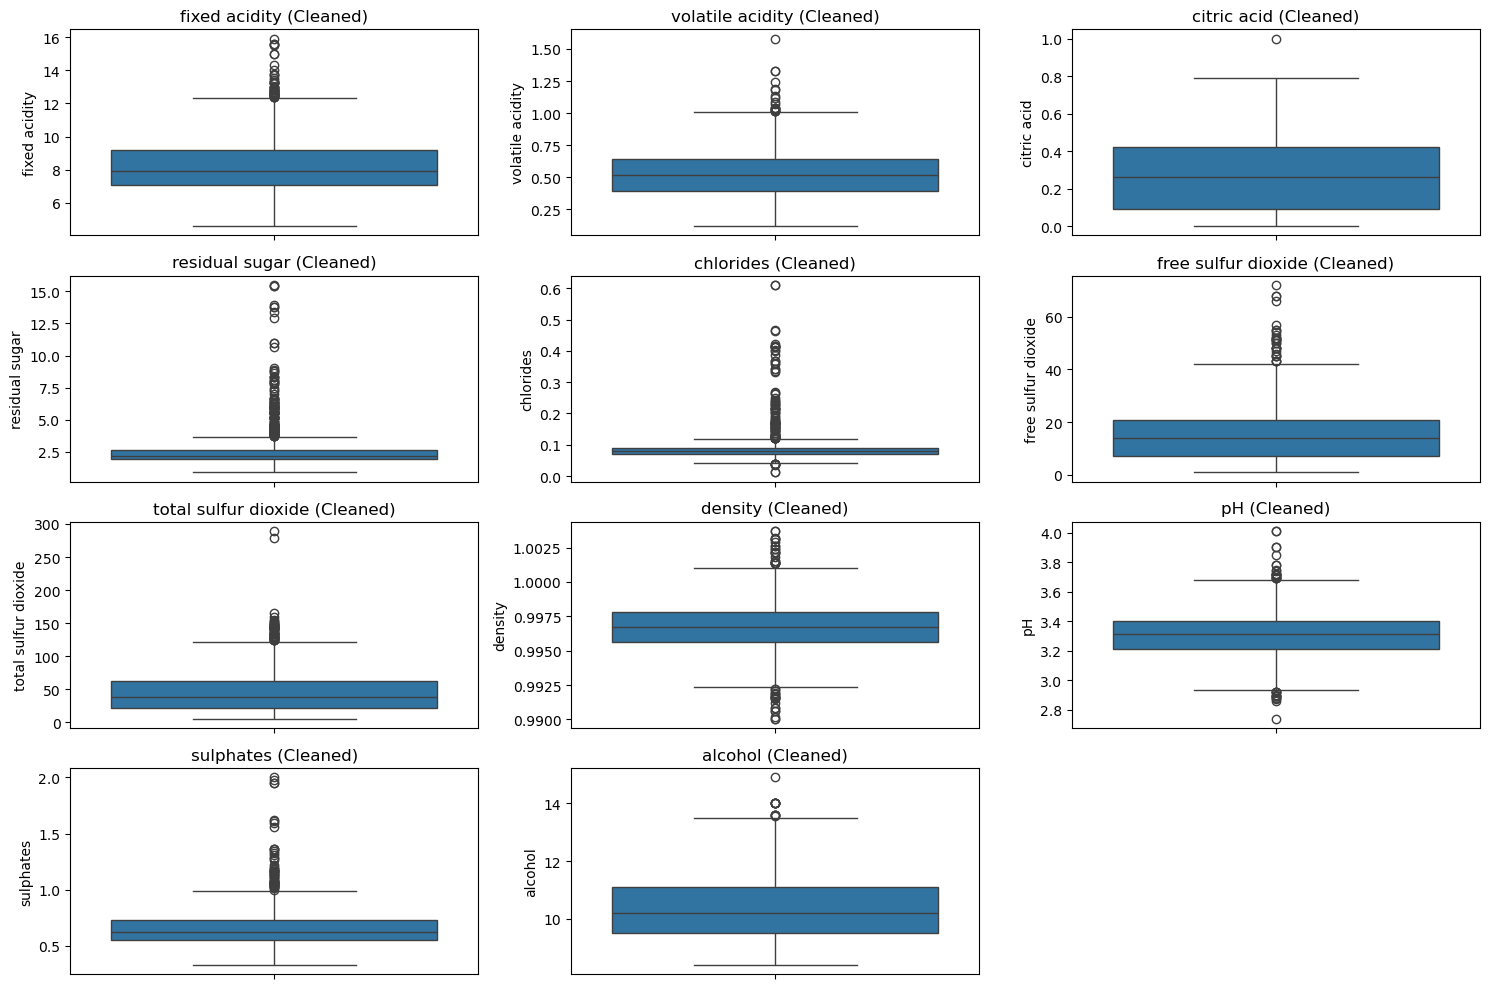

In [ ]:
# Visualize cleaned data (correctly use wine_cleaned here)
plt.figure(figsize=(15, 10))
for i, col in enumerate(wine_cleaned.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(y=wine_cleaned[col])
    plt.title(f"{col} (Capped)")
plt.tight_layout()
plt.show()

### <span style="color: brown;"> Feature Scaling <span>

If you scale the full dataset before splitting, you're leaking information from the test/validation sets into your training set.

This causes data leakage and leads to overly optimistic results — your model would be “cheating” by seeing statistics (like mean/std) from data it shouldn't know during training.

| Step | Action                          | Notes                            |
| ---- | ------------------------------- | -------------------------------- |
| 1️⃣  | `train_test_split()`            | Create X\_train, X\_val, X\_test |
| 2️⃣  | `scaler.fit_transform(X_train)` | Learn scaling from training only |
| 3️⃣  | `scaler.transform(X_val)`       | Apply same scaling to validation |
| 4️⃣  | `scaler.transform(X_test)`      | Apply same scaling to test       |


In [59]:

# 1. Use cleaned data from previous outlier handling
X = wine_cleaned.drop('quality', axis=1)
y = wine_cleaned['quality']

# 2. Check skewness of the target
print("Skewness of target variable (quality):", y.skew())
# You can optionally apply transformation if it's too skewed

# 3. Train/Validation/Test Split
features = X.columns
target = 'quality'

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=1234
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=1234
)

# 4. Scale the features (AFTER split — to avoid data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. Check shape
print(f"\nTrain: {len(X_train)} samples ({len(X_train)/len(wine_cleaned)*100:.1f}%)")
print(f"Val:   {len(X_val)} samples ({len(X_val)/len(wine_cleaned)*100:.1f}%)")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(wine_cleaned)*100:.1f}%)")



Skewness of target variable (quality): 0.21780157547366327

Train: 1155 samples (72.2%)
Val:   204 samples (12.8%)
Test:  240 samples (15.0%)


With a skewness of 0.22 for the target variable (quality), the data is approximately symmetric (since skewness between -0.5 and 0.5 is typically considered "fairly normal"). This is excellent for Linear Regression, as it satisfies the normality assumption for residuals.

Target Variable (quality)

* Skewness = 0.22 → Nearly symmetric (no transformation needed).

* Values range from 3–8 (mostly 5–6), treated as continuous for regression.

Features

* Mixed scales (e.g., alcohol (8-14%), chlorides (0.01-0.2), pH (2.7-4.0).

* Some features may be correlated (e.g., fixed acidity and pH).

### <span style="color: brown;"> Multicollinearity Check (VIF) <span>


Action: Drop features with VIF > 5-10 (e.g., fixed acidity or density if highly correlated).

In [ ]:
# 6. VIF Calculation on TRAIN data (scaled)
vif = pd.DataFrame()
vif["Feature"] = X_train.columns  # X_train is unscaled but has the correct feature names
vif["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors (VIF):")
print(vif.sort_values("VIF", ascending=False))


Variance Inflation Factors (VIF):
                 Feature       VIF
0          fixed acidity  7.419518
7                density  7.057522
10               alcohol  3.316821
8                     pH  3.154569
2            citric acid  3.047808
6   total sulfur dioxide  2.289624
5    free sulfur dioxide  2.011713
3         residual sugar  1.960395
1       volatile acidity  1.789640
9              sulphates  1.315461
4              chlorides  1.289702


## <span style="color: orange;"> Data Visualization <span>

### Distribution of Wine Quality Ratings

* Shows how many wines fall into each quality category (3-8).

* Helps identify class imbalance (e.g., very few "3" or "8" quality wines).

Skewed Predictions: The model may bias predictions toward 5–6.

Evaluation Metrics:

MAE (Mean Absolute Error): Better for imbalanced targets than MSE.

R²: May be misleading if the model only predicts the mean.

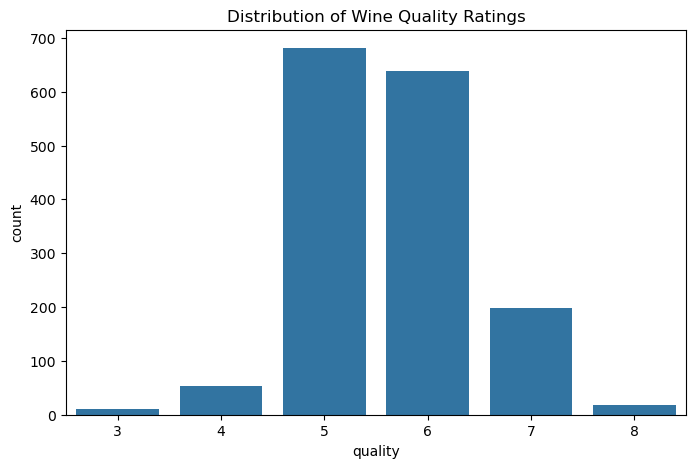

In [54]:
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=wine_data)
plt.title('Distribution of Wine Quality Ratings')
plt.show()

## Correlation Matrix

The correlation matrix (sns.heatmap) quantifies linear relationships between all pairs of features (including the target quality). Values range from -1 to 1:

1: Perfect positive correlation (e.g., alcohol and quality = 0.48).

-1: Perfect negative correlation (e.g., volatile acidity and quality = -0.39).

0: No linear relationship.

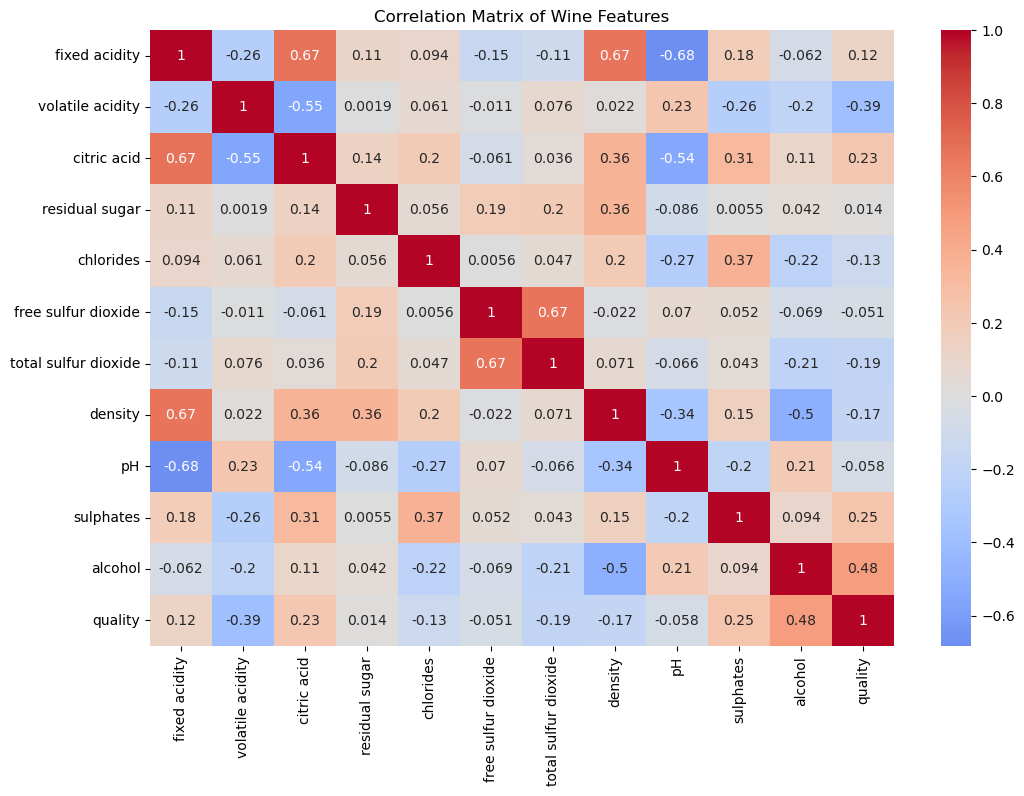

In [55]:
plt.figure(figsize=(12, 8))
corr = wine_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Wine Features')
plt.show()

| **Feature**          | **Correlation with Quality** | **Notable Cross-Feature Correlations**                                        |
| -------------------- | ---------------------------- | ----------------------------------------------------------------------------- |
| **Alcohol**          | **+0.48** (Strongest)        | Negatively correlated with **density** (*r* = -0.50)                          |
| **Volatile Acidity** | -0.39                        | Negatively correlated with **citric acid** (*r* = -0.55)                      |
| **Sulphates**        | +0.25                        | Weak correlations with other features                                         |
| **Fixed Acidity**    | +0.12                        | Highly correlated with **density** (*r* = +0.67) and **pH** (*r* = -0.68)     |
| **Density**          | -0.17                        | Correlated with **alcohol** (*r* = -0.50) and **fixed acidity** (*r* = +0.67) |


Feature Selection: Prioritize features with stronger correlations to quality (e.g., alcohol, volatile acidity).

Multicollinearity:

High correlation between predictors (e.g., fixed acidity ↔ density) inflates variance in coefficient estimates.
